### CA7 for Atmospheric Thermodynamic


### Import packages and set perameters

In [21]:
import Mog
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Open sounding file
H_env,P_env,T_env,RH_env = np.loadtxt(fname='46810-2018072200.edt.txt',dtype=float,usecols=(1,2,3,4),skiprows=3,delimiter=',',unpack=True)

# Set parameters
Q = 0.03  # sensible heat flux [mK/s]
R = 1.2e-4  # latent heat flux [(kg*m)/(kg*s)]
Rd = Mog.Rd  # [J/K*kg]
Rv = Mog.Rv  # [J/K*kg]
epsilon = Rd/Rv
g0 = Mog.g0  # [m/s^2]
Cp = Mog.Cp  # [J/K*kg]
Lv = Mog.Lv  # [J/kg]
A = 2.53*10**9  # hPa
B = 5.42*10**3  # K
Gamma_d = Mog.g0/Cp  # Dry adiabatic lapse rate [K/m]

# Calculate environment variables
T_env += 273.15
es_env = Mog.SaturationWaterVaporPressure(T_env)
es_env = es_env * RH_env * 0.01  # Water vapor pressure
qv_env = Mog.SpecificHumidity(P_env,es_env)
qvs_env = Mog.SpecificHumidity(P_env, es_env)
theta_env = Mog.PotentialTemp(T_env,P_env)
hm_env = Mog.MoistStaticEnergy(T_env, H_env, qv_env)
hms_env = Mog.MoistStaticEnergy(T_env, H_env, qvs_env)
Sd_env = Mog.DryStaticEnergy(T_env, H_env)


In [22]:
# Find according index
NTU = np.where(H_env == 22)[0][0]
House = np.where(H_env == 2594)[0][0]
Vally = np.where(H_env == 1501)[0][0]
Summit = np.where(H_env == 3743)[0][0]

# Routes
T_e = np.append(np.append(T_env[NTU:House+1], T_env[Vally:House+1][::-1]), T_env[Vally:Summit+1])
qv_e = np.append(np.append(qv_env[NTU:House+1], qv_env[Vally:House+1][::-1]), qv_env[Vally:Summit+1])
hm_e = np.append(np.append(hm_env[NTU:House+1], hm_env[Vally:House+1][::-1]), hm_env[Vally:Summit+1])
Sd_e = np.append(np.append(Sd_env[NTU:House+1], Sd_env[Vally:House+1][::-1]), Sd_env[Vally:Summit+1])
x = np.append(np.append(np.linspace(0,2,len(T_env[NTU:House+1])), np.linspace(2,3,len(T_env[Vally:House+1]))), np.linspace(3,5,len(T_env[Vally:Summit+1])))

## CA7-1 Mountain Climbing

Target:

        1. Tc 
        2. hm/Cp, Sd/Cp, T, qv

Initial:

        T = 27 [°C]
        RH = 75 [%]

*Assume that $q_v$ is const in PBL (well mix)*

#### Point 1: (22m) And find cloud base (592.2m)

H = 22 [m]; P = 1001.4 [hPa]

In [23]:
# Initial values (T, RH) @ 22m
T_1 = 27  # °C
T_K1 = 27 + 273.15  # K
RH = 0.75  # Relative Humidity
P = 1001.4  # hPa

# e and qv @ 22m
es_1 = Mog.SaturationWaterVaporPressure(T_K1)  # es @ 22m
qvs_1 = es_1 * Mog.epsilon / 1001.4  # qvs @ 22m
e_1 = es_1 * RH  # e @ 22m
qv_1 = qvs_1 * RH  # qv @ 22m

# Sd and hm
Sd_1 = Mog.Cp * T_K1 + Mog.g0 * 22  # Sd @ 22m
hm_1 = Mog.Cp * T_K1 + Mog.g0 * 22 + Mog.Lv * qv_1  # hm @ 22m

def f(Tc):
    # Set the values of the variables used in the function
    w = qv_1
    p0 = 1001.4
    T0 = T_K1
    ep = 0.622
    A = 2.53*10**9
    B = 5420
    kp = Mog.Cp/Mog.Rd
    # Calculate the value of the function and return it
    ans = Tc - B/np.log(((A*ep)/(w*p0))*(T0/Tc)**kp)
    return ans

# Calculating Tc and find cloud base
Tc = opt.bisect(f, 10, 400)
Cloudbase = (T_K1 - Tc)/Gamma_d + 22

print('Tc =', Tc, '[K]')
print('Cloud base =', Cloudbase, '[m]')


Tc = 294.3652353475184 [K]
Cloud base = 614.2413577614662 [m]


#### Point 2 (cloud base = 592.2m, P = 938.8 hPa)

T = Tc ;    
qv = qv @ cb

In [24]:
# Sd and hm @ cb
Sd_2 = Mog.Cp * Tc + Mog.g0 * Cloudbase  # Sd @ cb
hm_2 = Mog.Cp * Tc + Mog.g0 * Cloudbase + Mog.Lv * qv_1  # hm @ cb

# T and qv
qv_2 = Mog.SaturatedSpecificHumidity(Tc, 938.8)



#### Point 3 (2595m, P = 744 hPa) 

In [25]:
# T and qv
T_3 = 12.5
T_K3 = T_3 + 273.15
qvs_3 = 0.0123

# hm and Sd
Sd_3 = Mog.Cp * T_K3 + Mog.g0 * 2595  # Sd @ 2595m
hm_3 = Mog.Cp * T_K3 + Mog.g0 * 2595 + Mog.Lv * qvs_3  # hm @ 2595m


#### Point 4 (1500m, P = 846 hPa)

In [26]:
# T and qv
T_4 = 17.2
T_K4 = T_4 + 273.15
qvs_4 = 0.0147

# hm and Sd
Sd_4 = Mog.Cp * T_K4 + Mog.g0 * 1500
hm_4 = Mog.Cp * T_K4 + Mog.g0 * 1500 + Mog.Lv * qvs_4

#----------------------------------------------------------

# Irriversable
# T and qv (qv = qvs_3)
T_4r = T_3 + Gamma_d * (2595 - 1500)
T_K4r = T_4r + 273.15
print(T_4r)

# hm and Sd
Sd_4r = Mog.Cp * T_K4r + Mog.g0 * 1500
hm_4r = Mog.Cp * T_K4r + Mog.g0 * 1500 + Mog.Lv * qvs_3


23.195499750996014


#### Cloud base2 (irriversible) (=Point3)

In [27]:
# T and qv
Tc2 = T_K3
qv_cb2 = qvs_3

# hm and Sd
Sd_3 = Mog.Cp * Tc2 + Mog.g0 * 2595  # Sd @ 2595m
hm_3 = Mog.Cp * Tc2 + Mog.g0 * 2595 + Mog.Lv * qvs_3  # hm @ 2595m


#### Point 5 (3742m, P = 648 hPa)

In [28]:
# T and qv
T_5 = 7.2
T_K5 = T_5 + 273.15
qvs_5 = 0.01

# hm and Sd
Sd_5 = Mog.Cp * T_K5 + Mog.g0 * 3742
hm_5 = Mog.Cp * T_K5 + Mog.g0 * 3742 + Mog.Lv * qvs_5

#-----------------------------------------------------------

# Irriversible
# T and qv
T_5r = 12.1
T_K5r = T_5r + 273.15
qvs_5r = 0.0139

# hm and Sd
Sd_5r = Mog.Cp * T_K5r + Mog.g0 * 3742
hm_5r = Mog.Cp * T_K5r + Mog.g0 * 3742 + Mog.Lv * qvs_5r


#### Plot CA7-1

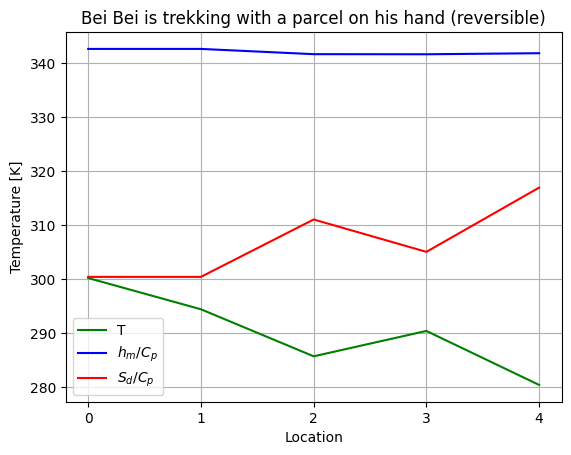

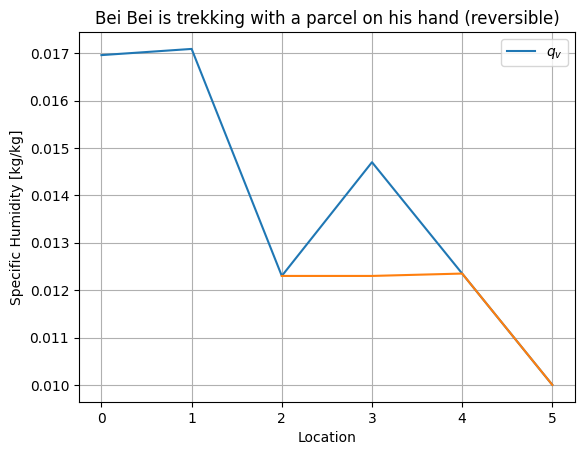

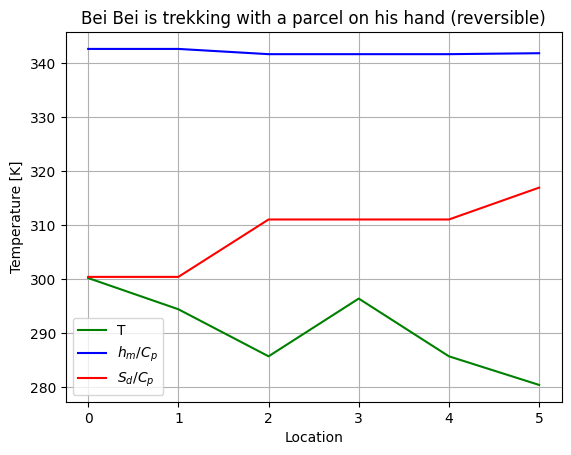

In [29]:
# Reversible
plt.plot([T_K1, Tc, T_K3, T_K4, T_K5], 'green')
plt.plot([hm_1/Mog.Cp, hm_2/Mog.Cp, hm_3/Mog.Cp, hm_4/Mog.Cp, hm_5/Mog.Cp], 'blue')
plt.plot([Sd_1/Mog.Cp, Sd_2/Mog.Cp, Sd_3/Mog.Cp, Sd_4/Mog.Cp, Sd_5/Mog.Cp], 'r')
plt.legend(['T', '$h_m$/$C_p$', '$S_d$/$C_p$'])
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('Location')
plt.ylabel('Temperature [K]')
plt.title('Bei Bei is trekking with a parcel on his hand (reversible)')
plt.grid()
plt.show()

plt.plot([qv_1, qv_2, qvs_3, qvs_4, (qvs_4+qvs_5)*0.5, qvs_5])
plt.plot([np.nan, np.nan, qvs_3, qvs_3, (qvs_4+qvs_5)*0.5, qvs_5])
plt.legend(['$q_v$'])
plt.xticks([0, 1, 2, 3, 4, 5])
plt.xlabel('Location')
plt.ylabel('Specific Humidity [kg/kg]')
plt.title('Bei Bei is trekking with a parcel on his hand (reversible)')
plt.grid()
plt.show()

# Irriversible
plt.plot([T_K1, Tc, T_K3, T_K4r, Tc2, T_K5], 'green')
plt.plot([hm_1/Mog.Cp, hm_2/Mog.Cp, hm_3/Mog.Cp, hm_4r/Mog.Cp, hm_3/Mog.Cp, hm_5/Mog.Cp], 'blue')
plt.plot([Sd_1/Mog.Cp, Sd_2/Mog.Cp, Sd_3/Mog.Cp, Sd_4r/Mog.Cp, Sd_3/Mog.Cp ,Sd_5/Mog.Cp], 'r')
plt.legend(['T', '$h_m$/$C_p$', '$S_d$/$C_p$'])
plt.xticks([0, 1, 2, 3, 4, 5])
plt.xlabel('Location')
plt.ylabel('Temperature [K]')
plt.title('Bei Bei is trekking with a parcel on his hand (reversible)')
plt.grid()
plt.show()




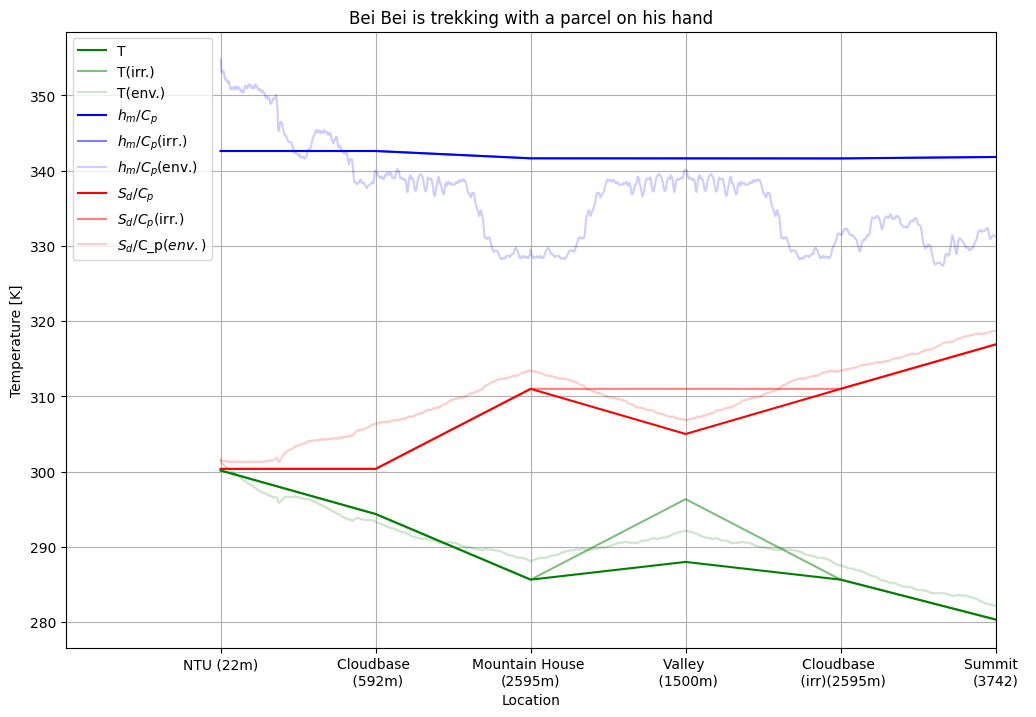

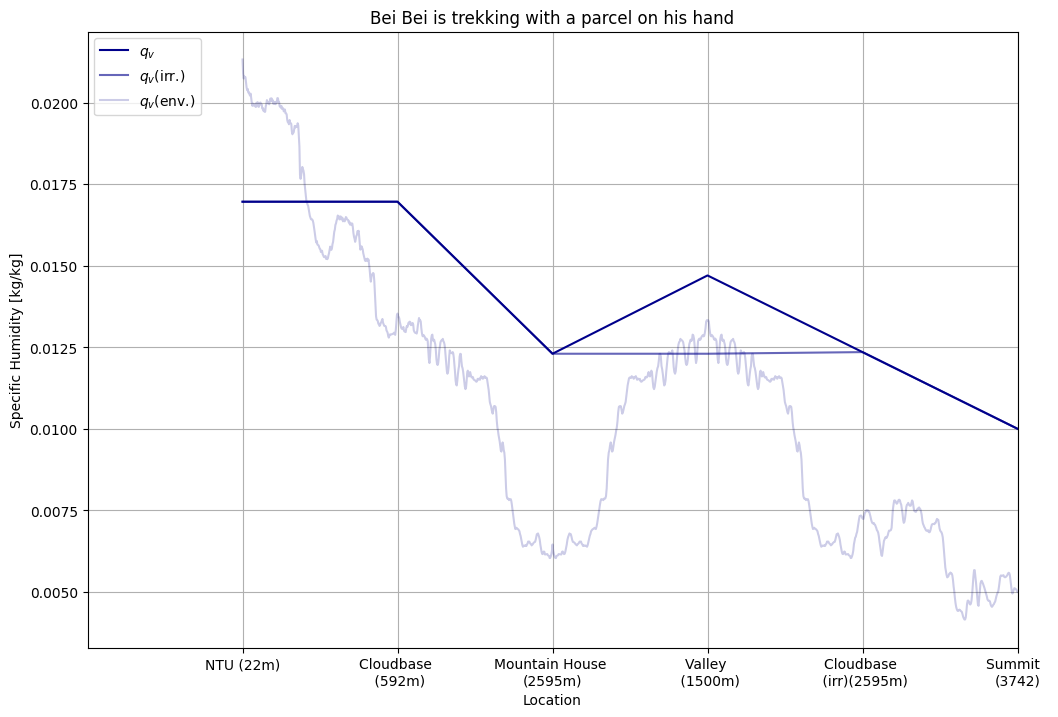

: 

In [30]:
T_re = [T_K1, Tc, T_K3, (T_K3 + T_K4)*0.5, T_K3, T_K5]
hm_re = [hm_1/Mog.Cp, hm_2/Mog.Cp, hm_3/Mog.Cp,  (hm_3/Mog.Cp + hm_4/Mog.Cp)*0.5, hm_4/Mog.Cp, hm_5/Mog.Cp]
Sd_re = [Sd_1/Mog.Cp, Sd_2/Mog.Cp, Sd_3/Mog.Cp, Sd_4/Mog.Cp, Sd_3/Mog.Cp, Sd_5/Mog.Cp]

T_irr = [T_K1, Tc, T_K3, T_K4r, Tc2, T_K5]
hm_irr = [hm_1/Mog.Cp, hm_2/Mog.Cp, hm_3/Mog.Cp, hm_4r/Mog.Cp, hm_3/Mog.Cp, hm_5/Mog.Cp]
Sd_irr = [Sd_1/Mog.Cp, Sd_2/Mog.Cp, Sd_3/Mog.Cp, Sd_4r/Mog.Cp, Sd_3/Mog.Cp ,Sd_5/Mog.Cp]

f, ax = plt.subplots(figsize=(12,8))
plt.plot(T_re, 'green')
plt.plot(T_irr, 'green', alpha = 0.5)
plt.plot(x,T_e, 'green', alpha = 0.2)
plt.plot(hm_re, 'blue')
plt.plot(hm_irr, 'blue', alpha = 0.5)
plt.plot(x,hm_e/Cp, 'blue', alpha = 0.2)
plt.plot(Sd_re, 'r')
plt.plot(Sd_irr, 'r', alpha = 0.5)
plt.plot(x,Sd_e/Cp, 'r', alpha = 0.2)
plt.legend(['T', 'T(irr.)', 'T(env.)', '$h_m$/$C_p$', '$h_m$/$C_p$(irr.)', '$h_m$/$C_p$(env.)', '$S_d$/$C_p$', '$S_d$/$C_p$(irr.)', '$S_d/$C_p$(env.)$'])
plt.xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(labels = ['NTU (22m)', 'Cloudbase \n (592m)', 'Mountain House \n(2595m)', 'Valley \n (1500m)', 'Cloudbase \n (irr)(2595m)', 'Summit  \n(3742)'])
plt.xlim(-1,5)
plt.xlabel('Location')
plt.ylabel('Temperature [K]')
plt.title('Bei Bei is trekking with a parcel on his hand')
plt.grid()
plt.show()

f, ax = plt.subplots(figsize=(12,8))
plt.plot([qv_1, qv_1, qvs_3, qvs_4, (qvs_4+qvs_5)*0.5, qvs_5], 'darkblue')
plt.plot([qv_1, qv_1, qvs_3, qvs_3, (qvs_4+qvs_5)*0.5, qvs_5], 'darkblue', alpha = 0.6)
plt.plot(x, qv_e, 'darkblue', alpha = 0.2)
plt.xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(labels = ['NTU (22m)', 'Cloudbase \n (592m)', 'Mountain House \n(2595m)', 'Valley \n (1500m)', 'Cloudbase \n (irr)(2595m)', 'Summit  \n(3742)'])
plt.xlim(-1,5)
plt.xlabel('Location')
plt.ylabel('Specific Humidity [kg/kg]')
plt.legend(['$q_v$', '$q_v$(irr.)', '$q_v$(env.)'], loc = 'upper left')
plt.title('Bei Bei is trekking with a parcel on his hand')
plt.grid()
plt.show()